<a href="https://colab.research.google.com/github/Taejin1221/Algorithm/blob/master/Trajectory_Clustering_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import modules

In [1]:
import os, cv2, glob
import numpy as np
import pandas as pd

'''
If you want to know this file,
refer to https://github.com/smupilab/Trajectory-AE/blob/master/utils/convertImage.py
'''
from drive.MyDrive.University.PiLab.Experiment.Codes import convertImage as utils

In [2]:
os.getcwd()

'/content'

# Set Constants

In [3]:
# Constants
WIDTH, HEIGHT = 128, 128

EXPERIMENT_DATA = { 'name' : 'Trajectory_Clusetring', 'number' : '3', 'date' : '02-25-2021' }

ROOT_DIR = os.path.join('/content', 'drive','MyDrive','University','PiLab','Experiment' )
DATA_DIR = os.path.join( ROOT_DIR, 'Data', 'Trajectory_virtual_data')
RESULT_DIR = os.path.join( ROOT_DIR, 'Results')

# Load and Preprocessing Data

In [4]:
os.chdir( DATA_DIR )

files = glob.glob( '*csv' )

generator = utils.Map2ImageGenerator( WIDTH, HEIGHT, 0 )

images = [ ]
for file in files:
    csv_file = pd.read_csv( file, names = [ 'lat', 'long', 'num' ], header = None )

    images.append( generator.ConvertImage( csv_file ) )

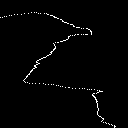

In [5]:
from google.colab.patches import cv2_imshow

cv2_imshow( images[0] )

In [6]:
images = np.array( images ).astype( 'float32' ) / 255.
images = np.reshape( images, ( -1, HEIGHT, WIDTH, 1 ) )

In [7]:
train_size = int( len( images ) * 0.8 )
X_train, X_test = images[ : train_size], images[train_size : ]

# Construct AE Model

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
af, pd = 'relu', 'same' # activation function adn padding value

encode_input = layers.Input( ( WIDTH, HEIGHT, 1 ) )
x = layers.Conv2D( 16, ( 9, 9 ), activation = af, padding = pd )( encode_input )
x = layers.MaxPooling2D( ( 2, 2 ), padding = pd )( x )

x = layers.Conv2D( 16, ( 7, 7 ), activation = af, padding = pd )( x )
x = layers.MaxPooling2D( ( 2, 2 ), padding = pd )( x )

x = layers.Conv2D( 8, ( 5, 5 ), activation = af, padding = pd )( x )
x = layers.MaxPooling2D( ( 2, 2 ), padding = pd )( x )

x = layers.Conv2D( 8, ( 3, 3 ), activation = af, padding = pd )( x )
x = layers.MaxPooling2D( ( 2, 2 ), padding = pd )( x )

feature_map_shape = x.shape
flatten_size = feature_map_shape[1] * feature_map_shape[2] * feature_map_shape[3]

x = layers.Flatten()( x )
encode_output = layers.Dense( flatten_size , activation = af )( x )

In [10]:
encoder = keras.Model( encode_input, encode_output, name = 'Encoder' )
encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      1312      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        12560     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 8)         3208      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 8)         0   

In [11]:
decode_input = layers.Input( ( flatten_size ) )

x = layers.Dense( flatten_size, activation = af )( decode_input )
x = layers.Reshape( feature_map_shape[1:] )( x )

x = layers.Conv2DTranspose( 8, ( 3, 3 ), activation = af, padding = pd )( x )
x = layers.UpSampling2D( ( 2, 2 ) )( x )

x = layers.Conv2DTranspose( 8, ( 5, 5 ), activation = af, padding = pd )( x )
x = layers.UpSampling2D( ( 2, 2 ) )( x )

x = layers.Conv2DTranspose( 16, ( 7, 7 ), activation = af, padding = pd )( x )
x = layers.UpSampling2D( ( 2, 2 ) )( x )

x = layers.Conv2DTranspose( 16, ( 9, 9 ), activation = af, padding = pd )( x )
x = layers.UpSampling2D( ( 2, 2 ) )( x )

decode_output = layers.Conv2DTranspose( 1, ( 9, 9 ), activation = af, padding = pd )( x )

In [12]:
decoder = keras.Model( decode_input, decode_output, name = 'Decoder' )
decoder.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 8)           584       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 8)         1608      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 8)         0   

In [13]:
auto_encoder = keras.Model( encode_input, decoder( encoder( encode_input ) ), name = 'Auto_Encoder' )
auto_encoder.summary()

Model: "Auto_Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
Encoder (Functional)         (None, 512)               280320    
_________________________________________________________________
Decoder (Functional)         (None, 128, 128, 1)       293185    
Total params: 573,505
Trainable params: 573,505
Non-trainable params: 0
_________________________________________________________________


# Traing Model

In [14]:
LAMBDA1, LAMBDA2 = 0.15, 0.85

def SSIM_Loss( y_true, y_pred ):
    ssim = tf.image.ssim( y_true, y_pred, max_val = 1.0, filter_size = 11,
                          filter_sigma = 1.5, k1 = 0.01, k2 = 0.03)
    
    return 1 - tf.reduce_mean( ssim )

def Hybrid_Loss( y_true, y_pred ):
    f1 = keras.losses.MAE( y_true, y_pred )
    f2 = SSIM_Loss( y_true, y_pred )

    return LAMBDA1 * f1 + LAMBDA2 * f2

# auto_encoder.compile( 'adam', loss = Hybrid_Loss )
auto_encoder.compile( 'adam', loss = 'mse' )

In [15]:
EPOCH = 300
BATCH = 10

In [16]:
history = auto_encoder.fit( X_train, X_train, epochs = EPOCH, batch_size = BATCH )

Epoch 1/300
6/6 [==============================] - 8s 37ms/step - loss: 0.0110
Epoch 2/300
6/6 [==============================] - 0s 9ms/step - loss: 0.0112
Epoch 3/300
6/6 [==============================] - 0s 9ms/step - loss: 0.0107
Epoch 4/300
6/6 [==============================] - 0s 9ms/step - loss: 0.0107
Epoch 5/300
6/6 [==============================] - 0s 9ms/step - loss: 0.0112
Epoch 6/300
6/6 [==============================] - 0s 9ms/step - loss: 0.0109
Epoch 7/300
6/6 [==============================] - 0s 9ms/step - loss: 0.0109
Epoch 8/300
6/6 [==============================] - 0s 9ms/step - loss: 0.0109
Epoch 9/300
6/6 [==============================] - 0s 9ms/step - loss: 0.0108
Epoch 10/300
6/6 [==============================] - 0s 9ms/step - loss: 0.0109
Epoch 11/300
6/6 [==============================] - 0s 9ms/step - loss: 0.0105
Epoch 12/300
6/6 [==============================] - 0s 10ms/step - loss: 0.0105
Epoch 13/300
6/6 [==============================] - 0s 9ms/

# Test Model

## Check Reconstruction

Trajectory_Clusetring_3_Reconstruction(02-25-2021).png


<Figure size 432x288 with 0 Axes>

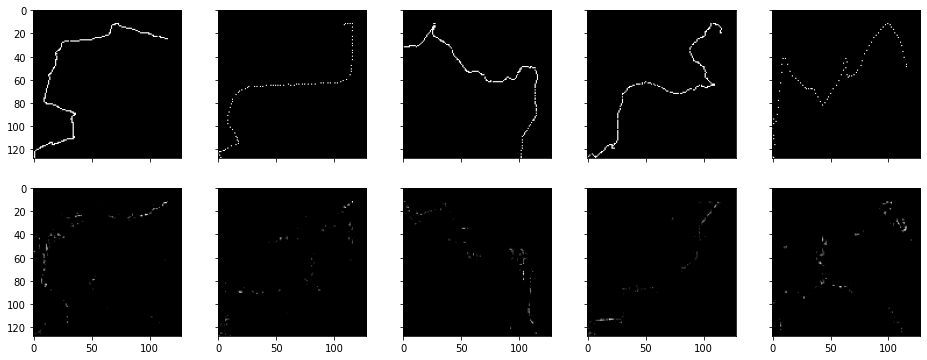

In [17]:
import matplotlib.pyplot as plt

os.chdir( RESULT_DIR )

decoded_img = auto_encoder( X_test )

plt.gray()
n = 5
fig, ax = plt.subplots( 2, n, True, True, figsize = ( 16, 6 ) )
for i in range( n ):
    ax[0][i].imshow( X_test[i].reshape( HEIGHT, WIDTH ) )
    ax[1][i].imshow( tf.reshape( decoded_img[i], ( HEIGHT, WIDTH ) ) )

result_name = (EXPERIMENT_DATA['name'] + '_'
    + EXPERIMENT_DATA['number'] + '_'
    + 'Reconstruction' + '('
    + EXPERIMENT_DATA['date'] + ').png')
print( result_name )

plt.savefig( result_name, dpi = 300 )
plt.show()

## Clustering (HCA)

Trajectory_Clusetring_3_Clustering(02-25-2021).png


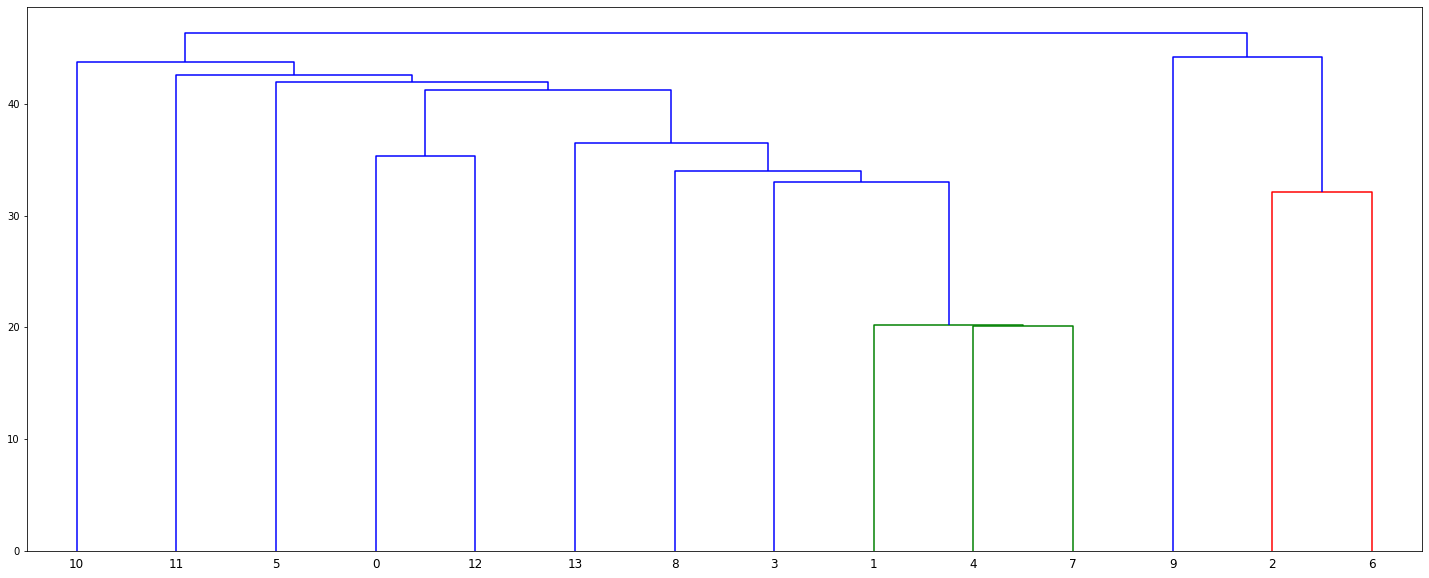

In [18]:
from scipy.cluster.hierarchy import dendrogram, linkage
low_dimension_data = encoder( X_test )
result = linkage( low_dimension_data )

fig = plt.figure( figsize = ( 25, 10 ) )
dn = dendrogram( result )

result_name = (EXPERIMENT_DATA['name'] + '_'
    + EXPERIMENT_DATA['number'] + '_'
    + 'Clustering' + '('
    + EXPERIMENT_DATA['date'] + ').png')
print( result_name )

plt.savefig( result_name, dpi = 300 )
plt.show()

<Figure size 432x288 with 0 Axes>

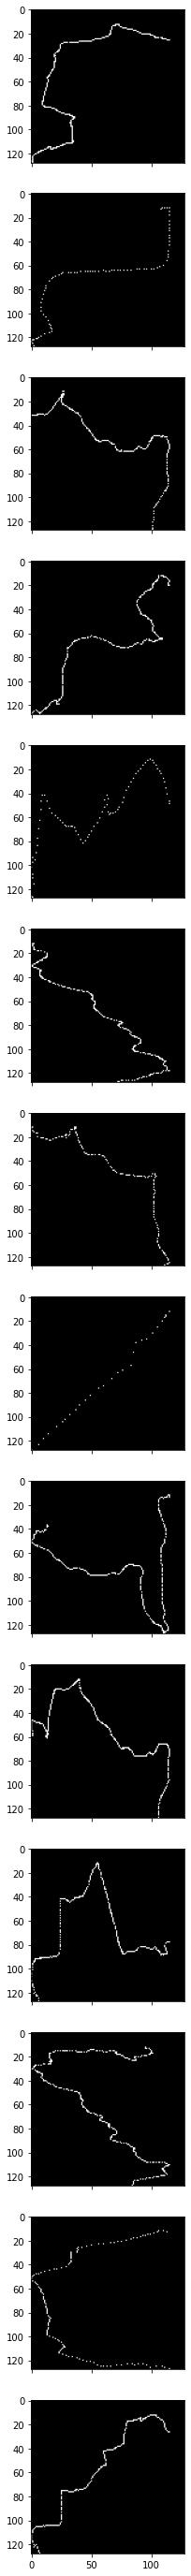

In [19]:
plt.gray()
n = len( X_test )
fig, ax = plt.subplots( n, 1, True, True, figsize = ( 24, 50 ) )
for i in range( n ):
    ax[i].imshow( X_test[i].reshape( HEIGHT, WIDTH ) )
    # ax[1][i].imshow( tf.reshape( decoded_img[i], ( HEIGHT, WIDTH ) ) )